In [1]:
%matplotlib ipympl

In [2]:
%matplotlib widget

In [3]:
"""Visualise output of condensation process."""

import argparse
import sys
import os

import matplotlib.collections
import matplotlib.lines
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np

from pecan.utilities import parse_keys
from pecan.utilities import make_tensor
from pecan.utilities import get_limits

import json

In [4]:
def total_persistence(diagram, p=2):
    """Calculate total persistence of a persistence diagram."""
    return np.sum(np.power(np.abs(np.diff(diagram[:, 0:2])), 2))

In [5]:
def update(i):
    """Update callback for the animation."""
    # Update time-varying point cloud, similarly to the other plotting
    # scripts.
    scatter.set_offsets(X[..., i])
    ax[0].set_title(f'Data (2D) @ $t={i}$')

    persistence_diagram.set_offsets(pds[i][:, 0:2])
    ax[1].set_title(f'Persistence diagram @ $t={i}$')

Run 

`python condensation.py --data=double_annulus -o=data/publication/double_annulus.npz --force`

In [8]:
INPUT = "../pecan/data/publication/double_annulus.npz" 
frame = None
start_frame = frame if frame is not None else 0

interval = 200
repeat = False

# Load data and check whether all keys are available. We require
# only the diffusion homology pairs and the data set here.
data = np.load(INPUT, allow_pickle=True)
parsed_keys = parse_keys(data)

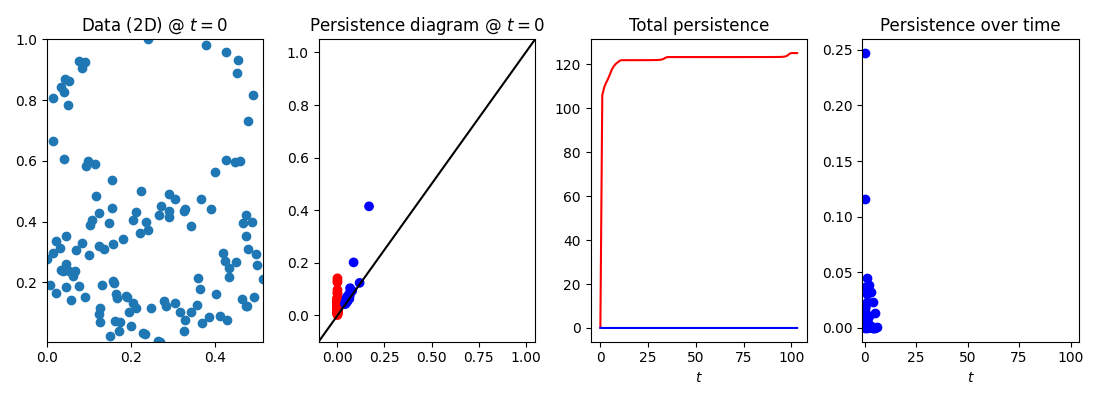

In [9]:
assert 'data' in parsed_keys, 'Require "data" key'

assert 'lawvere_persistence_pairs' in parsed_keys, \
    'Require "lawvere_persistence_pairs" key'

X = make_tensor(data, parsed_keys['data'])
T = X.shape[-1]

# Plot dynamic point cloud first. This assumes that only two
# dimensions are available; higher-dimensional data may need
# an additional dimensionality reduction step before-hand.
fig, ax = plt.subplots(ncols=4, figsize=(11, 4))


x_min, x_max, y_min, y_max = get_limits(X)

ax[0].set_title(f'Data (2D) @ $t = {start_frame}$')
ax[0].set_xlim((x_min, x_max))
ax[0].set_ylim((y_min, y_max))

# Render first time step before the animation starts.
scatter = ax[0].scatter(X[:, 0, 0], X[:, 1, 0])

# Set up the diffusion homology pairing. This just amounts to
# accessing the distribution of pairs and turning them into a
# barcode visualisation.

# List of persistence pairs of the form (creation, destruction). An
# optional third dimension is ignored.
pds = [
    data[key] for key, _ in parsed_keys['lawvere_persistence_points']
]




y_max = 0.0
for pd in pds:
    y_max = max(y_max, np.max(pd[:, 1]))

ax[1].set_xlim(-0.1, y_max * 1.05)
ax[1].set_ylim(-0.1, y_max * 1.05)
ax[1].axline((-0.1, -0.1), slope=1.0, c='k')
ax[1].set_title(f'Persistence diagram @ $t={start_frame}$')

cm = matplotlib.colors.ListedColormap(['r', 'b'])

# Show the diagram of the initial point cloud
persistence_diagram = ax[1].scatter(
    x=pds[start_frame][:, 0],
    y=pds[start_frame][:, 1],
    c=pds[start_frame][:, 2],
    cmap=cm,
)



# Basic animation setup; it will loop over all the frames in the
# data set and depict the corresponding topological features in
# a barcode plot.


if frame is None:
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=T,
        interval=interval,
        repeat=repeat,
    )


# Plot total persistence for every time step; this is a cumulative
# sum of the persistence values.




for dimension in [0, 1]:
    diagrams = [d[d[:, 2] == dimension] for d in pds]
    values = [total_persistence(d) for d in diagrams]

    ax[2].plot(values, c=cm(dimension))
    ax[2].set_title('Total persistence')
    ax[2].set_xlabel('$t$')

# Persistence values as time-varying scatterplots. This is kind of
# a *projection* of all topological features, but at least, we see
# their behaviour over time (without tracking).
#
# TODO: does it make sense to do this for other dimensions that
# dimension 1?
for dimension in [1]:
    diagrams = [d[d[:, 2] == dimension] for d in pds]
    values = [np.abs(np.diff(d[:, 0:2])).flatten() for d in diagrams]

    ax[3].set_xlim(-1, len(values))

    for index, value in enumerate(values):
        ax[3].scatter(
            y=value,
            x=[index] * len(value),
            color=cm(dimension),
        )

ax[3].set_title('Persistence over time')
ax[3].set_xlabel('$t$')
plt.tight_layout()